# Route planning based on predicted crash likelihood
## Steps
1. Take node graph (consolidated? probably)
1. Pick a starting and ending location
1. Calculate route based on travel length/time
1. Make up environmental conditions for a given day
1. Predict danger/likelihood of crash at each node on route
    * Report average danger
    * Highlight route based on likelihood of crash
1. Predict danger/likelihood of crash at remaining nodes in graph
    * Assign attribute of crash likelihood to each node
1. Recalculate route, optimizing for likelihood of crash
    * Report average danger
    * Highlight route based on likelihood of crash

In [1]:
import pandas as pd
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from collections import Counter

In [2]:
GRAPH_FILEPATH = "../../pipeline_data/2019/target_map_consolidated.graphml"
MODEL_FILEPATH = "../../data/random_forest_model.pkl"

In [3]:
import pickle
with open(MODEL_FILEPATH, "rb") as f:
    model = pickle.load(f)

In [4]:
G = ox.io.load_graphml(GRAPH_FILEPATH)

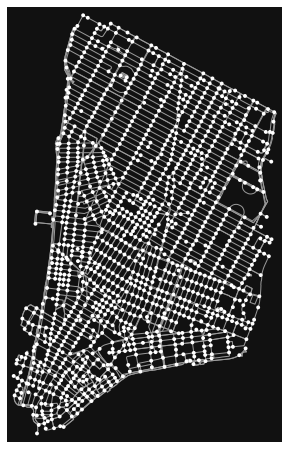

In [5]:
fig, ax = ox.plot.plot_graph(G)
plt.show()

In [6]:
import geopandas as gpd
from shapely.geometry import Point

starting_point_coord = (40.713060, -74.007235)
ending_point_coord = (40.734910, -73.979821)

d = {
    'col1': ['start', 'end'],
    'geometry': [
        Point(starting_point_coord[1], starting_point_coord[0]),
        Point(ending_point_coord[1], ending_point_coord[0])
    ]
}

gdf = gpd.GeoDataFrame(d, crs="EPSG:4326").to_crs("EPSG:32618")

print(gdf)

    col1                        geometry
0  start  POINT (583854.729 4507378.680)
1    end  POINT (586142.133 4509830.714)


In [7]:
gdf.loc[0, "geometry"].x

583854.7288008638

In [8]:
orig = ox.distance.nearest_nodes(G, gdf.loc[0, "geometry"].x, gdf.loc[0, "geometry"].y, return_dist=False)
dest = ox.distance.nearest_nodes(G, gdf.loc[1, "geometry"].x, gdf.loc[1, "geometry"].y, return_dist=False)

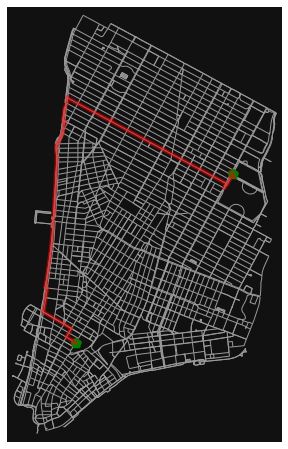

In [9]:
route = ox.shortest_path(G, orig, dest, weight="travel_time")

fig, ax = ox.plot_graph_route(G, route, node_size=0, close=False, show=False)
ax.scatter(G.nodes[orig]["x"], G.nodes[orig]["y"], marker="*", c="green", linewidths=5)
ax.scatter(G.nodes[dest]["x"], G.nodes[dest]["y"], marker="*", c="green", linewidths=5)
plt.show()

## Predict crash likelihood on route
Columns:
* 'EVENT_DATE'
* 'EVENT_TIME'
* 'AWND'
* 'PGTM'
* 'PRCP'
* 'SNOW'
* 'SNWD'
* 'WT01'
* 'WT02'
* 'WT03'
* 'WT04'
* 'WT05'
* 'WT06'
* 'WT08'
* 'WT09'
* 'WT11',
* 'residential'
* 'service'
* 'secondary'
* 'primary'
* 'cycleway'
* 'unclassified'
* 'trunk'
* 'pedestrian'
* 'tertiary'
* 'path'
* 'secondary_link'
* 'living_street'
* 'primary_link'
* TAVG

### DEFINITION
* WT01: Fog, ice fog, or freezing fog (may include heavy fog)
* WT02: Heavy fog or heaving freezing fog (not always distinguished from fog)
* WT03: Thunder
* WT04: Ice pellets, sleet, snow pellets, or small hail
* WT05: Hail (may include small hail)
* WT06: Glaze or rime
* WT08: Smoke or haze
* WT09: Blowing or drifting snow
* WT11: High or damaging winds
* WT13: Mist
* WT14: Drizzle
* WT15: Freezing Drizzle
* WT16: Rain (may include freezing rain, drizzle, and freezing drizzle)
* WT18: Snow, snow pellets, snow grains, or ice crystals
* WT19: Unknown source of precipitation
* WT22: Ice fog or freezing fog

In [10]:
def get_node_crash_attributes(crashes_df: pd.DataFrame, G):
    """
    Get the attributes of each node based on crashes and road types
    """
    num_node_crashes = get_num_node_crashes(G, crashes_df)

    for node, attrs in num_node_crashes.items():
        if node:
            for road_type, num_roads in count_road_types(G, node).items():
                attrs[road_type] = num_roads

    if 0 in num_node_crashes:
        _ = num_node_crashes.pop(0)

    return num_node_crashes


def count_road_types(_graph, node: int):
    """
    Count types of roads at a node

    Args:
        node (int): The node ID

    Returns:
        Dict[str, int]: Dictionary of road types and counts
    """
    roads = get_roads_at_node(_graph, node)

    # Need to unpack, because some returns from OSMnx can be a list of multiple road types
    flat_list_roads = []
    for sublist in roads:
        if type(sublist)==list:
            for item in sublist:
                flat_list_roads.append(item)
        else:
            flat_list_roads.append(sublist)

    return dict(Counter(flat_list_roads))


def get_roads_at_node(_graph, node: int):
    """
    Get all roads that are present (converge) at a given node in graph self._graph

    Args:
        node (int): The node ID

    Returns:
        List[str]: Road types for all edges that meet at the given node
    """
    all_edges = get_node_edges(_graph, node)
    
    roads = []
    
    for edge in all_edges:
        edge_roads = get_edge_road(_graph, edge)
        
        for road in edge_roads:
            roads.append(road)

    return roads


def get_edge_road(_graph, edge: tuple) -> str:
    """
    Get the road type of a given edge

    Args:
        edge (tuple): The tuple that defines an edge

    Returns:
        str: The type of road
    """
    roads = []
    edge_attrs = get_edge_attributes(_graph, edge)
    
    for i in edge_attrs.values():
        roads.append(i.get("highway", "N/A"))
    
    return roads


def get_edge_attributes(_graph, edge: tuple) -> dict:
    """
    Get the attributes of a given edge in graph self._graph

    Args:
        edge (tuple): The tuple that defines an edge

    Returns:
        dict: The attribute dictionary for a given edge. Example is:
        {0: {
                'osmid': [421853954, 421853949],
                'oneway': True,
                'lanes': '5',
                'name': '1st Avenue',
                'highway': 'primary',
                'maxspeed': '25 mph',
                'length': 81.28,
                'geometry': <shapely.geometry.linestring.LineString at 0x7fcd2b43a670>
        }}
    """
    return _graph.get_edge_data(edge[0], edge[1])


def get_node_edges(_graph, node: int):
    """
    Get all nodes at an edge in graph self._graph

    Args:
        node (int): The ID of a given node in the graph

    Returns:
        List[tuple]: List of tuples for each edge that meets at the node
    """
    in_edges = list(_graph.in_edges(node))
    out_edges = list(_graph.out_edges(node))

    #TODO: Could there be repeats between in- and out-edges?

    return in_edges + out_edges

In [11]:
node_roads = {}

for i in G.nodes:
    node_roads[i] = count_road_types(G, i)

In [12]:
node_roads[0]

{'residential': 5}

In [13]:
other_attrs = {
    "EVENT_DATE": 31+28+31+4, # April 4th
    "EVENT_TIME": 10 * 60, # 10 AM
    "AWND": 0,
    "PGTM": 0,
    "PRCP": 0,
    "SNOW": 0,
    "SNWD": 0,
    "WT01": 0,
    "WT02": 0,
    "WT03": 0,
    "WT04": 0,
    "WT05": 0,
    "WT06": 0,
    "WT08": 0,
    "WT09": 0,
    "WT11": 0,
    "TAVG": 45,
}

In [14]:
{**node_roads[0], **other_attrs}

{'residential': 5,
 'EVENT_DATE': 94,
 'EVENT_TIME': 600,
 'AWND': 0,
 'PGTM': 0,
 'PRCP': 0,
 'SNOW': 0,
 'SNWD': 0,
 'WT01': 0,
 'WT02': 0,
 'WT03': 0,
 'WT04': 0,
 'WT05': 0,
 'WT06': 0,
 'WT08': 0,
 'WT09': 0,
 'WT11': 0,
 'TAVG': 45}

In [15]:
node_attrs = {}

for i in G.nodes:
    node_attrs[i] = {**node_roads[i], **other_attrs}

In [16]:
node_attrs_df = pd.DataFrame.from_dict(
    node_attrs,
    orient="index",
    columns=[
        "EVENT_DATE",
        "EVENT_TIME",
        "AWND",
        "PGTM",
        "PRCP",
        "SNOW",
        "SNWD",
        "WT01",
        "WT02",
        "WT03",
        "WT04",
        "WT05",
        "WT06",
        "WT08",
        "WT09",
        "WT11",
        'residential',
        'service',
        'secondary',
        'primary',
        'cycleway',
        'unclassified',
        'trunk',
        'pedestrian',
        'tertiary',
        'path',
        'secondary_link',
        'living_street',
        'primary_link',
        "TAVG"
    ]
).fillna(0)

In [17]:
node_attrs_df

,EVENT_DATE,EVENT_TIME,AWND,PGTM,PRCP,SNOW,SNWD,WT01,WT02,WT03,...,cycleway,unclassified,trunk,pedestrian,tertiary,path,secondary_link,living_street,primary_link,TAVG
0,94,600,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45
1,94,600,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45
2,94,600,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45
3,94,600,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45
4,94,600,0,0,0,0,0,0,0,0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,94,600,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45
1259,94,600,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45
1260,94,600,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45
1261,94,600,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45


In [18]:
node_crash_preds = model.predict_proba(node_attrs_df)

In [19]:
node_crash_likelihood = node_crash_preds[:, 1]

In [20]:
len(node_crash_likelihood)

1263

In [21]:
node_crash_likelihood_df = pd.Series(node_crash_likelihood, index=node_attrs_df.index)

In [22]:
node_crash_likelihood_df

0       0.249503
1       0.321108
2       0.321108
3       0.260833
4       0.184109
          ...   
1258    0.279771
1259    0.243097
1260    0.337867
1261    0.289085
1262    0.289085
Length: 1263, dtype: float64

In [23]:
node_crash_likelihood_df.describe()

count    1263.000000
mean        0.283131
std         0.054686
min         0.093229
25%         0.254767
50%         0.272193
75%         0.294332
max         0.562617
dtype: float64

In [24]:
node_crash_likelihood_df[0]

0.24950272657941844

## Edge crash probability
Assign the probability of a crash at each node to the edges, so that we can optimize for safety

In [25]:
G[0][1][0]

{'osmid': 194923763,
 'name': 'East 10th Street',
 'highway': 'residential',
 'maxspeed': '20 mph',
 'oneway': False,
 'length': 101.449,
 'geometry': <shapely.geometry.linestring.LineString at 0x7fa268de0be0>,
 'u_original': '42421828',
 'v_original': '42430942'}

In [26]:
for i in G.edges:
#     node_1 = G.nodes[i[0]]
#     node_2 = G.nodes[i[1]]
    
    edge_danger = (node_crash_likelihood_df[i[0]] + node_crash_likelihood_df[i[1]]) / 2
    
    for j in range(i[2]+1):
        G[i[0]][i[1]][j]["crash_prob"] = edge_danger

## Route danger
First, get danger on the original route. Then, recalculate route, optimizing for danger

In [27]:
route[:5]

[1219, 287, 288, 530, 531]

In [28]:
route_dangers = []

for i, j in zip(route, route[1:]):
    # We can use 0, since we assigned the same crash prob for all edges between consolidated nodes
    route_dangers.append(G.get_edge_data(i, j)[0]["crash_prob"])
    

In [29]:
average_danger = np.mean(route_dangers)
max_danger = np.max(route_dangers)
min_danger = np.min(route_dangers)
median_danger = np.median(route_dangers)

print("Route Danger Metrics:\nAvg prob: {0}\nMax prob: {1}\nMin prob: {2}\nMed prob: {3}".format(
    average_danger, max_danger, min_danger, median_danger
))

Route Danger Metrics:
Avg prob: 0.2838856828509981
Max prob: 0.3496357980812938
Min prob: 0.20232760599078808
Med prob: 0.28728227670081563


In [30]:
node_pairs = list(zip(route[:-1], route[1:]))

x = np.array([])
y = np.array([])

for (u, v) in node_pairs:
    data = min(G.get_edge_data(u, v).values(), key=lambda d: d["crash_prob"])
    
    if "geometry" in data:
        _x, _y = data["geometry"].xy
        x = np.append(x, _x)
        y = np.append(y, _y)
        
    else:
        x = np.append(x, G.nodes[u]["x"], G.nodes[v]["x"])
        y = np.append(y, G.nodes[u]["y"], G.nodes[v]["y"])
        
points = np.array([x, y]).T.reshape(-1, 1, 2)

segments = np.concatenate([points[:-1], points[1:]], axis=1)

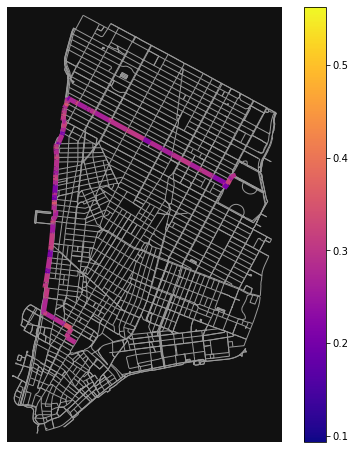

In [31]:
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0)

norm = plt.Normalize(node_crash_likelihood_df.min(), node_crash_likelihood_df.max())
lc = LineCollection(segments, cmap='plasma', norm=norm)
# Set the values used for colormapping
lc.set_array(np.array(route_dangers))
lc.set_linewidth(5)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)

plt.show()

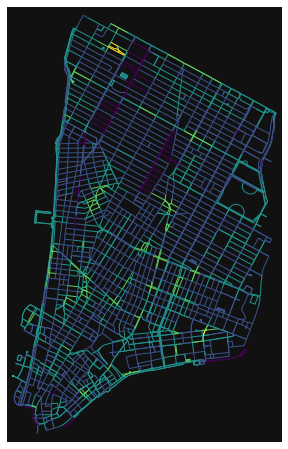

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [32]:
# Visualize all edge crash probs
ec = ox.plot.get_edge_colors_by_attr(G, attr='crash_prob', num_bins=5)
ox.plot.plot_graph(G, node_size=0, edge_color=ec)

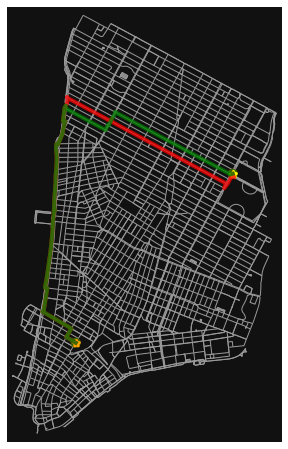

In [33]:
safe_route = ox.shortest_path(G, orig, dest, weight="crash_prob")

fig, ax = ox.plot_graph_routes(
    G,
    [route, safe_route],
    node_size=0,
    close=False,
    show=False,
    route_colors=["red", "green"],
    route_alpha=0.75
)

ax.scatter(G.nodes[orig]["x"], G.nodes[orig]["y"], marker="*", c="orange", linewidths=3)
ax.scatter(G.nodes[dest]["x"], G.nodes[dest]["y"], marker="*", c="yellow", linewidths=3)
plt.show()

In [34]:
route_dangers = []

for i, j in zip(safe_route, safe_route[1:]):
    # We can use 0, since we assigned the same crash prob for all edges between consolidated nodes
    route_dangers.append(G.get_edge_data(i, j)[0]["crash_prob"])
    
    
average_danger = np.mean(route_dangers)
max_danger = np.max(route_dangers)
min_danger = np.min(route_dangers)
median_danger = np.median(route_dangers)

print("Route Danger Metrics:\nAvg prob: {0}\nMax prob: {1}\nMin prob: {2}\nMed prob: {3}".format(
    average_danger, max_danger, min_danger, median_danger
))

Route Danger Metrics:
Avg prob: 0.26447006634519665
Max prob: 0.3273253573620115
Min prob: 0.15773607678663087
Med prob: 0.2770305379971978


In [35]:
node_pairs = list(zip(safe_route[:-1], safe_route[1:]))

x = np.array([])
y = np.array([])

for (u, v) in node_pairs:
    data = min(G.get_edge_data(u, v).values(), key=lambda d: d["crash_prob"])
    
    if "geometry" in data:
        _x, _y = data["geometry"].xy
        x = np.append(x, _x)
        y = np.append(y, _y)
        
    else:
        x = np.append(x, G.nodes[u]["x"], G.nodes[v]["x"])
        y = np.append(y, G.nodes[u]["y"], G.nodes[v]["y"])
        
points = np.array([x, y]).T.reshape(-1, 1, 2)

segments = np.concatenate([points[:-1], points[1:]], axis=1)

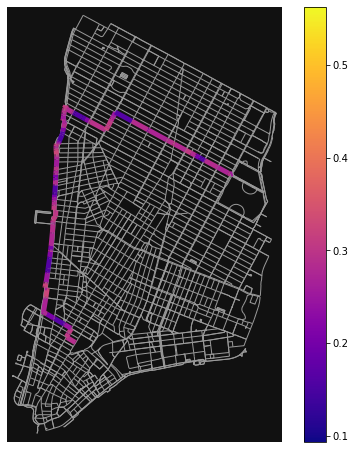

In [36]:
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0)

norm = plt.Normalize(node_crash_likelihood_df.min(), node_crash_likelihood_df.max())
lc = LineCollection(segments, cmap='plasma', norm=norm)
# Set the values used for colormapping
lc.set_array(np.array(route_dangers))
lc.set_linewidth(5)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)

plt.show()

In [37]:
len(route)

29

In [38]:
len(safe_route)

30

In [39]:
for i, j in zip(route, safe_route):
    print(i==j)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


### Function-ize
Formalize code into reusable funcs

In [40]:
def set_day_conditions(
    graph,
    node_roads,
    event_date,
    event_time,
    tavg=0,
    awnd=0,
    pgtm=0,
    prcp=0,
    snow=0,
    snwd=0,
    wt01=0,
    wt02=0,
    wt03=0,
    wt04=0,
    wt05=0,
    wt06=0,
    wt08=0,
    wt09=0,
    wt11=0
):
    other_attrs = {
        "EVENT_DATE": event_date,
        "EVENT_TIME": event_time,
        "AWND": awnd,
        "PGTM": pgtm,
        "PRCP": prcp,
        "SNOW": snow,
        "SNWD": snwd,
        "WT01": wt01,
        "WT02": wt02,
        "WT03": wt03,
        "WT04": wt04,
        "WT05": wt05,
        "WT06": wt06,
        "WT08": wt08,
        "WT09": wt09,
        "WT11": wt11,
        "TAVG": tavg,
    }

    
    node_attrs = {}

    for i in graph.nodes:
        node_attrs[i] = {**node_roads[i], **other_attrs}
        
    node_attrs_df = pd.DataFrame.from_dict(
        node_attrs,
        orient="index",
        columns=[
            "EVENT_DATE",
            "EVENT_TIME",
            "AWND",
            "PGTM",
            "PRCP",
            "SNOW",
            "SNWD",
            "WT01",
            "WT02",
            "WT03",
            "WT04",
            "WT05",
            "WT06",
            "WT08",
            "WT09",
            "WT11",
            'residential',
            'service',
            'secondary',
            'primary',
            'cycleway',
            'unclassified',
            'trunk',
            'pedestrian',
            'tertiary',
            'path',
            'secondary_link',
            'living_street',
            'primary_link',
            "TAVG"
        ]
    ).fillna(0)
        
    return node_attrs_df

In [41]:
def assign_edge_crash_prob(graph, node_crash_likelihood_df):
    """
    Assign the probability of a crash to each edge
    
    graph: The graph
    node_crash_likelihood_df: DF of predicted crash likelihood per node in graph
    """
    for i in graph.edges:
        edge_danger = (node_crash_likelihood_df[i[0]] + node_crash_likelihood_df[i[1]]) / 2

        for j in range(i[2]+1):
            graph[i[0]][i[1]][j]["crash_prob"] = edge_danger
            
    return graph

In [42]:
def predict_graph_crash_proba(model, node_attrs_df):
    """
    Predict the probability of a crash at each node
    """
    node_crash_preds = model.predict_proba(node_attrs_df)
    node_crash_likelihood = node_crash_preds[:, 1]
    node_crash_likelihood_df = pd.Series(node_crash_likelihood, index=node_attrs_df.index)
    return node_crash_likelihood_df

In [43]:
def get_route_dangers(route, graph):
    route_dangers = []

    for i, j in zip(route, route[1:]):
        # We can use 0, since we assigned the same crash prob for all edges between consolidated nodes
        route_dangers.append(graph.get_edge_data(i, j)[0]["crash_prob"])
        
    average_danger = np.mean(route_dangers)
    max_danger = np.max(route_dangers)
    min_danger = np.min(route_dangers)
    median_danger = np.median(route_dangers)

    print("Route Danger Metrics:\nAvg prob: {0}\nMax prob: {1}\nMin prob: {2}\nMed prob: {3}".format(
        average_danger, max_danger, min_danger, median_danger
    ))
    
    print("TOTAL DANGER: {}".format(np.sum(route_dangers)))
    
    return route_dangers

In [44]:
def plot_route_by_metric(route, graph, metric):
    """
    For a given input route on a graph, visualize the route colored by the metric it is optimized for
    """
    
    node_pairs = list(zip(route[:-1], route[1:]))

    x = np.array([])
    y = np.array([])

    for (u, v) in node_pairs:
        data = min(graph.get_edge_data(u, v).values(), key=lambda d: d[metric])

        if "geometry" in data:
            _x, _y = data["geometry"].xy
            x = np.append(x, _x)
            y = np.append(y, _y)

        else:
            x = np.append(x, graph.nodes[u]["x"], graph.nodes[v]["x"])
            y = np.append(y, graph.nodes[u]["y"], graph.nodes[v]["y"])

    points = np.array([x, y]).T.reshape(-1, 1, 2)

    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments

In [45]:
def plot_colored_route(graph, color_lim_min, color_lim_max, segments, route_metrics):
    """
    """
    fig, ax = ox.plot_graph(graph, show=False, close=False, node_size=0)

    norm = plt.Normalize(color_lim_min, color_lim_max)
    lc = LineCollection(segments, cmap='plasma', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.array(route_metrics))
    lc.set_linewidth(5)
    line = ax.add_collection(lc)
    fig.colorbar(line, ax=ax)

    plt.show()

In [46]:
set_day_conditions(G, node_roads, 31+28+31+4, 10*60, tavg=45)

,EVENT_DATE,EVENT_TIME,AWND,PGTM,PRCP,SNOW,SNWD,WT01,WT02,WT03,...,cycleway,unclassified,trunk,pedestrian,tertiary,path,secondary_link,living_street,primary_link,TAVG
0,94,600,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45
1,94,600,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45
2,94,600,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45
3,94,600,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45
4,94,600,0,0,0,0,0,0,0,0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,94,600,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45
1259,94,600,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45
1260,94,600,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45
1261,94,600,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45


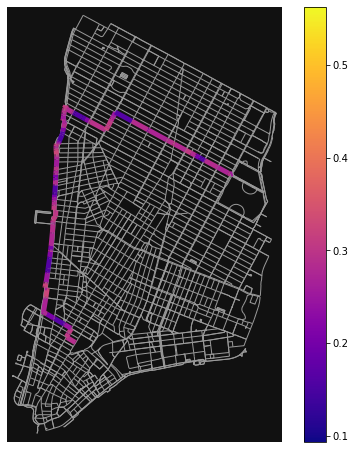

In [47]:
segments = plot_route_by_metric(safe_route, G, "crash_prob")
plot_colored_route(G, node_crash_likelihood_df.min(), node_crash_likelihood_df.max(), segments, route_dangers)

## Changing route conditions
Now we will recalculate the same route, but for different road conditions to see how the model influences the route (different time of day, different weather, etc)

Route Danger Metrics:
Avg prob: 0.2676843605581444
Max prob: 0.3490358869524824
Min prob: 0.18698703489400315
Med prob: 0.2571211528512215
TOTAL DANGER: 7.762846456186186


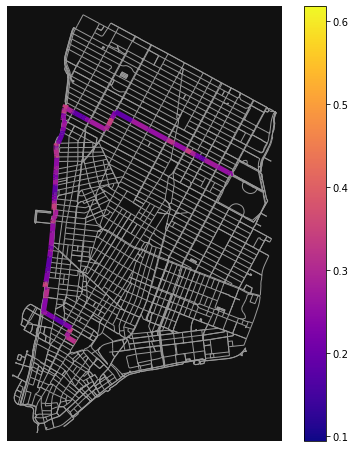

In [48]:
node_attrs_df = set_day_conditions(G, node_roads, 31+28, 10*60, tavg=20)
node_crash_likelihood_df = predict_graph_crash_proba(model, node_attrs_df)

G_no_snow = assign_edge_crash_prob(G.copy(), node_crash_likelihood_df)

safe_route_no_snow = ox.shortest_path(G_no_snow, orig, dest, weight="crash_prob")
route_dangers = get_route_dangers(safe_route_no_snow, G_no_snow)

segments = plot_route_by_metric(safe_route_no_snow, G_no_snow, "crash_prob")
plot_colored_route(G_no_snow, node_crash_likelihood_df.min(), node_crash_likelihood_df.max(), segments, route_dangers)

Route Danger Metrics:
Avg prob: 0.3417007552551915
Max prob: 0.41217019496530993
Min prob: 0.24356946051672318
Med prob: 0.34533328813750613
TOTAL DANGER: 9.567621147145362


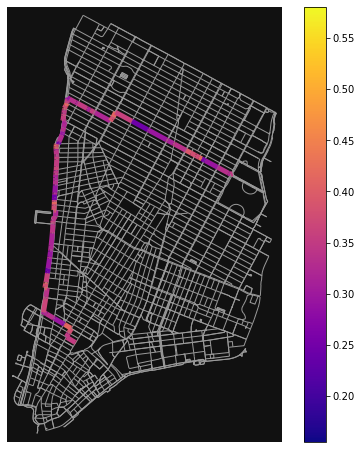

In [49]:
node_attrs_df = set_day_conditions(G, node_roads, 31+28, 10*60, tavg=20, snow=5)
node_crash_likelihood_df = predict_graph_crash_proba(model, node_attrs_df)

G_snow = assign_edge_crash_prob(G.copy(), node_crash_likelihood_df)

safe_route_snow = ox.shortest_path(G_snow, orig, dest, weight="crash_prob")
route_dangers = get_route_dangers(safe_route_snow, G_snow)

segments = plot_route_by_metric(safe_route_snow, G_snow, "crash_prob")
plot_colored_route(G_snow, node_crash_likelihood_df.min(), node_crash_likelihood_df.max(), segments, route_dangers)

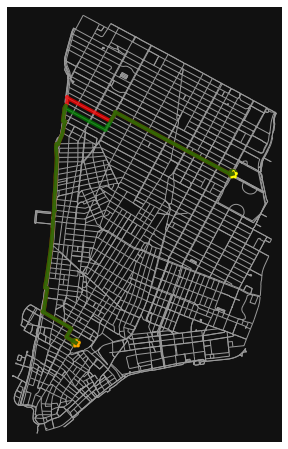

In [50]:
fig, ax = ox.plot_graph_routes(
    G,
    [safe_route_snow, safe_route_no_snow],
    node_size=0,
    close=False,
    show=False,
    route_colors=["red", "green"],
    route_alpha=0.75
)

ax.scatter(G.nodes[orig]["x"], G.nodes[orig]["y"], marker="*", c="orange", linewidths=3)
ax.scatter(G.nodes[dest]["x"], G.nodes[dest]["y"], marker="*", c="yellow", linewidths=3)
plt.show()

## Heatmap changes
Also want to show how the edge heatmap changes for different conditions

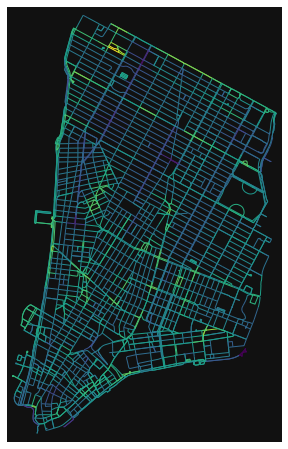

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [51]:
# Visualize all edge crash probs
ec = ox.plot.get_edge_colors_by_attr(G_snow, attr='crash_prob', stop=1)
ox.plot.plot_graph(G_snow, node_size=0, edge_color=ec)

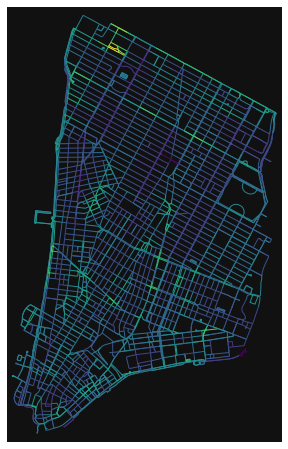

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [52]:
ec = ox.plot.get_edge_colors_by_attr(G_no_snow, attr='crash_prob', stop=1)
ox.plot.plot_graph(G_no_snow, node_size=0, edge_color=ec)

In [53]:
for i in G.edges:
    diff = G_snow[i[0]][i[1]][0]["crash_prob"] - G_no_snow[i[0]][i[1]][0]["crash_prob"]
    
    for j in range(i[2]+1):
        G[i[0]][i[1]][j]["crash_diff"] = diff

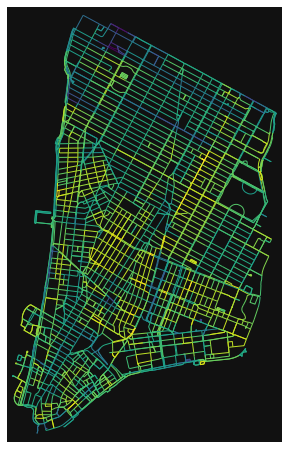

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [54]:
ec = ox.plot.get_edge_colors_by_attr(G, attr='crash_diff', stop=1, start=0)
ox.plot.plot_graph(G, node_size=0, edge_color=ec)

Route Danger Metrics:
Avg prob: 0.2676843605581443
Max prob: 0.34903588695248233
Min prob: 0.18698703489400315
Med prob: 0.2571211528512215
TOTAL DANGER: 7.762846456186185


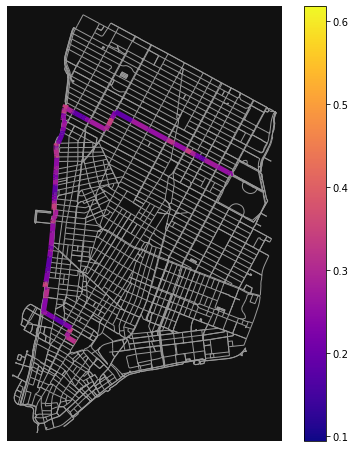

In [55]:
node_attrs_df = set_day_conditions(G, node_roads, 31+28, 10*60, tavg=20)
node_crash_likelihood_df = predict_graph_crash_proba(model, node_attrs_df)

G_10am = assign_edge_crash_prob(G.copy(), node_crash_likelihood_df)

safe_route_snow = ox.shortest_path(G_10am, orig, dest, weight="crash_prob")
route_dangers = get_route_dangers(safe_route_snow, G_10am)

segments = plot_route_by_metric(safe_route_snow, G_10am, "crash_prob")
plot_colored_route(G_10am, node_crash_likelihood_df.min(), node_crash_likelihood_df.max(), segments, route_dangers)

Route Danger Metrics:
Avg prob: 0.24925227489940455
Max prob: 0.3876441177051837
Min prob: 0.12607637205648917
Med prob: 0.24736198208915813
TOTAL DANGER: 7.228315972082732


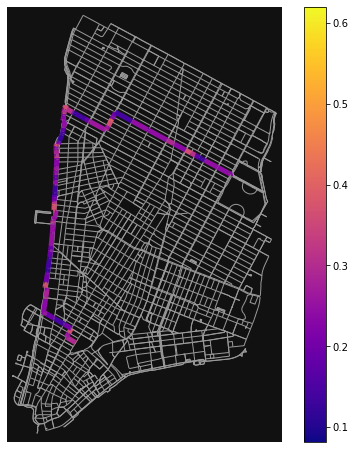

In [56]:
node_attrs_df = set_day_conditions(G, node_roads, 31+28, 18*60, tavg=20)
node_crash_likelihood_df = predict_graph_crash_proba(model, node_attrs_df)

G_6pm = assign_edge_crash_prob(G.copy(), node_crash_likelihood_df)

safe_route_snow = ox.shortest_path(G_6pm, orig, dest, weight="crash_prob")
route_dangers = get_route_dangers(safe_route_snow, G_6pm)

segments = plot_route_by_metric(safe_route_snow, G_6pm, "crash_prob")
plot_colored_route(G_6pm, node_crash_likelihood_df.min(), node_crash_likelihood_df.max(), segments, route_dangers)

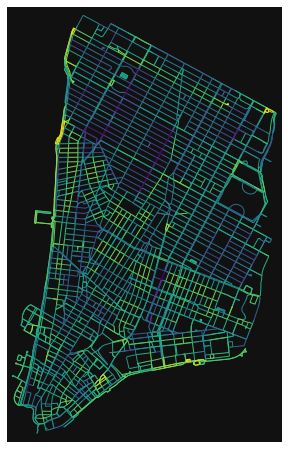

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [57]:
for i in G.edges:
    diff = G_6pm[i[0]][i[1]][0]["crash_prob"] - G_10am[i[0]][i[1]][0]["crash_prob"]
    
    for j in range(i[2]+1):
        G[i[0]][i[1]][j]["crash_diff"] = diff
        
ec = ox.plot.get_edge_colors_by_attr(G, attr='crash_diff', stop=1, start=0)
ox.plot.plot_graph(G, node_size=0, edge_color=ec)